In [495]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.geometry.analysis import Analysis
from ase.io import read
from tqdm.notebook import tqdm

In [2]:
def maxwell(x, t):
    return 4 * np.pi * (2 * np.pi * t) ** -1.5 * x ** 2 * np.exp(- x ** 2 / (2 * t))
def gauss(x, t):
    return (2 * np.pi * t) ** -.5 * np.exp(-x ** 2 / (2 * t))

### Визуализация потенциала

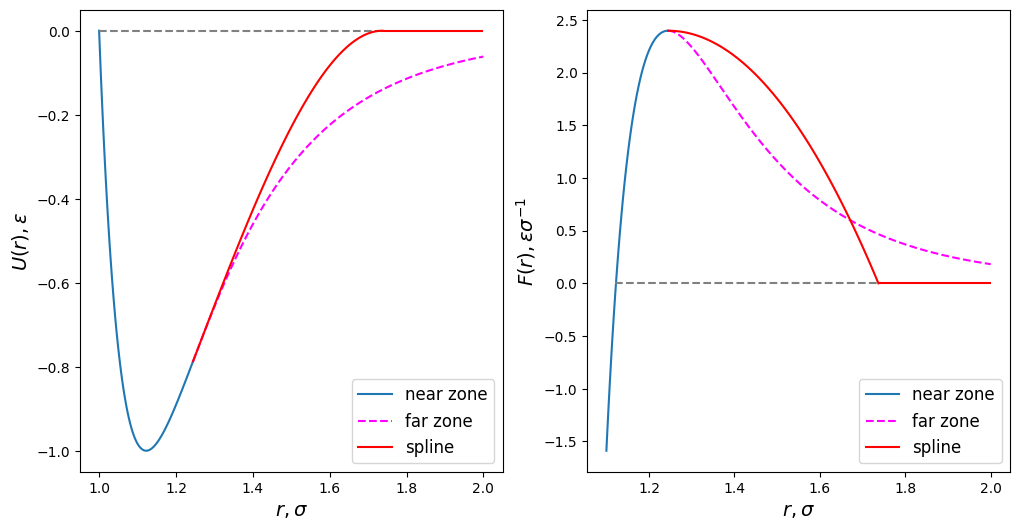

In [147]:
rs =  1.244455060259808
rc =  1.737051854945982
k1 = -3.292002800390959
k2 = -4.864890082711485

t1 = np.linspace(1, rs, 100)
t2 = np.linspace(rs, rc, 100)
t3 = np.linspace(rs, 2, 150)
t = np.linspace(1, rc, 200)

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].plot(t1, 4 * (t1 ** -12 - t1 ** -6), label='near zone')
ax[0].hlines(0, 1, rc, 'grey', linestyles='--')
ax[0].plot(t3, 4 * (t3 ** -12 - t3 ** -6), '--', c='magenta', label='far zone')
ax[0].plot(t2, k1 * (t2 - rc) ** 3 + k2 * (t2 - rc) ** 2, c='red', label='spline')
ax[0].hlines(0, rc, 2, colors='red')

ax[0].set_ylabel('$U(r), \\varepsilon$', fontsize=14)
ax[0].set_xlabel('$r, \\sigma$', fontsize=14)

ax[0].legend(loc='lower right', fontsize=12)

t1 = np.linspace(1.1, rs, 100)
t = np.linspace(1.1, rc, 100)

ax[1].plot(t1, 4 * ( -12 * t1 ** -13 + 6 * t1 ** -7 ), label='near zone' )
ax[1].plot(t3, 4 * ( -12 * t3 ** -13 + 6 * t3 ** -7 ), '--', c='magenta', label='far zone')
ax[1].hlines(0, 1.12, rc, colors='grey', linestyles='--')
ax[1].plot(t2, ( 3 * k1 * (t2 - rc) ** 2 + 2 * k2 * (t2 - rc) ), c='red', label='spline')
ax[1].hlines(0, rc, 2, colors='red')

ax[1].set_ylabel('$F(r), \\varepsilon \\sigma^{-1}$', fontsize=14)
ax[1].set_xlabel('$r, \\sigma$', fontsize=14)

ax[1].legend(loc='lower right', fontsize=12)

plt.show()

## Проверка алгоритма

```
    ./bin/generator -d 0.04 -c 6 -t 1.5 -f energy-law.mdl
    ./bin/model --input configs/energy-law.mdl -t 150 --ovito 100
```

### Сохранение энергии

In [155]:
e = np.fromfile('./outputs/energy-law-energy.dat', dtype=np.float64).reshape(-1, 2)

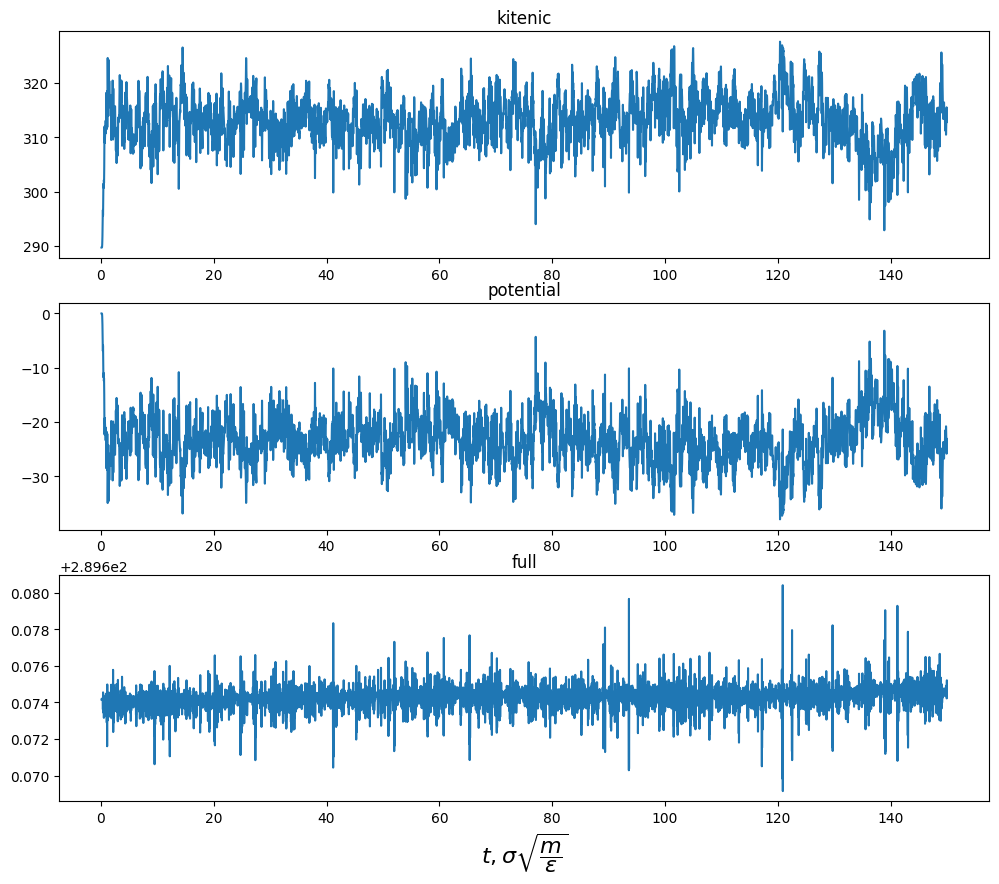

In [162]:
cut = 100

t = np.arange(cut * 0.001, e.shape[0] * 0.001, 0.001)

fig, ax = plt.subplots(3, 1, figsize=(12,10))
ax[0].plot(t, e[cut:,0])
ax[1].plot(t, e[cut:,1])
ax[2].plot(t, e[cut:].sum(axis=-1))

ax[0].set_title('kitenic')
ax[1].set_title('potential')
ax[2].set_title('full')

ax[2].set_xlabel('$t, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=16)

plt.show()

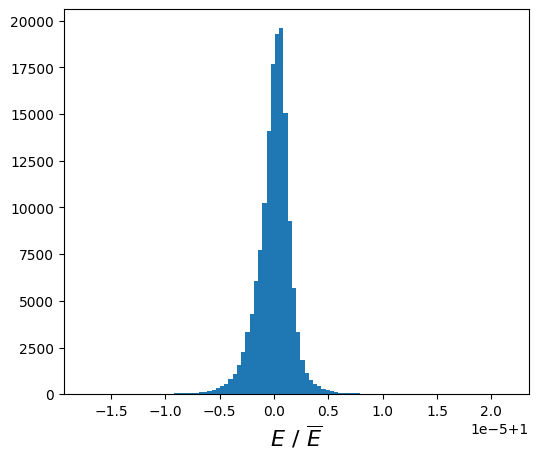

In [166]:
cut = 100

plt.figure(figsize=(6,5))

plt.hist(((e[cut:,0]+e[cut:,1]) / (e[cut:,0]+e[cut:,1]).mean()), bins=100)

plt.xlabel('$E ~/~ \overline{E}$', fontsize=16)

plt.show()

### Сохранение импульса

In [167]:
d = np.fromfile('./outputs/energy-law.dat', dtype=np.float64).reshape(-1, 125, 6)

In [263]:
p = d[100:,:,3:].sum(axis=1)

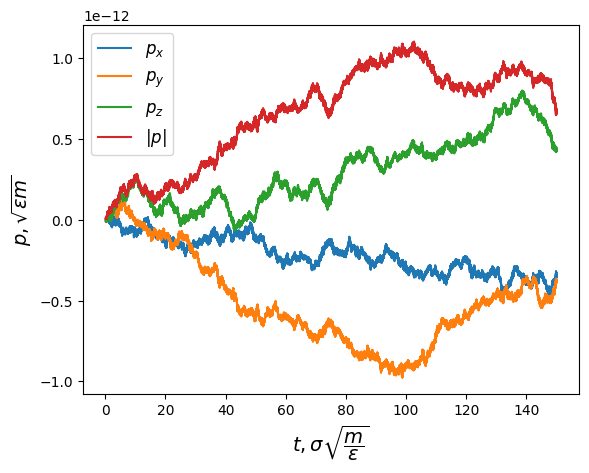

In [273]:
t = np.arange(0.1, 150, 1e-3)

plt.plot(t, p[:,0], label='$p_x$')
plt.plot(t, p[:,1], label='$p_y$')
plt.plot(t, p[:,2], label='$p_z$')
plt.plot(t, np.sqrt((p ** 2).sum(axis=-1)), label='$|p|$' )

plt.xlabel('$t, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=14)
plt.ylabel('$p, \sqrt{\\varepsilon m}$', fontsize=14)

plt.legend(fontsize=12)

plt.show()

### Распределение Максвелла

In [159]:
v = np.sqrt((d[100:,:,3:] ** 2).sum(axis=-1))

1.6825222228820484


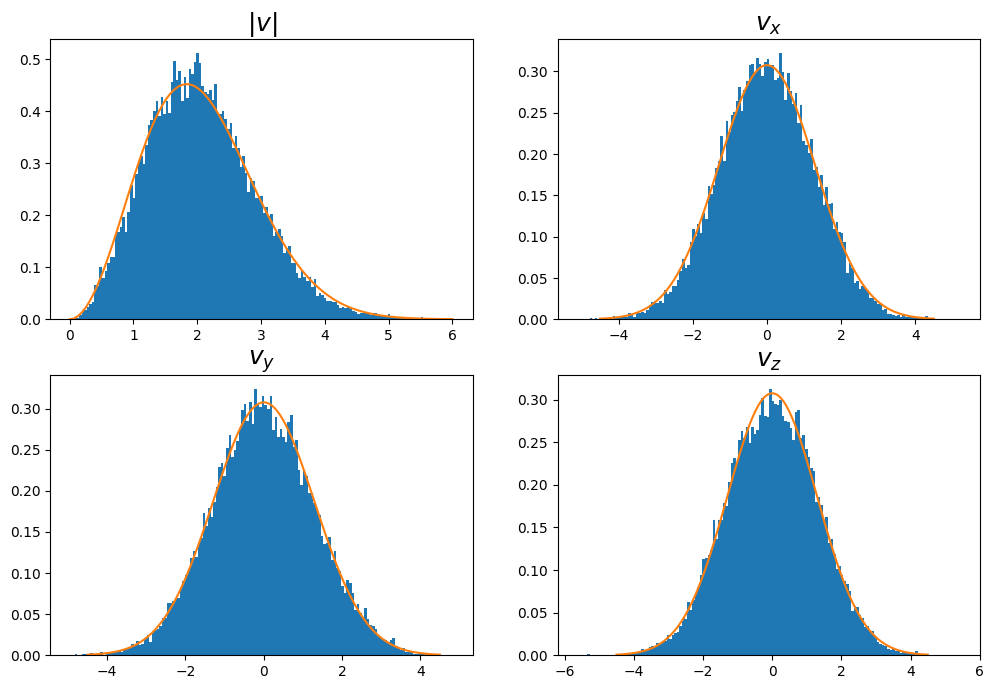

In [256]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0][0].hist(v.flatten(), bins=150, density=True)

T = ((e[-1000:-1,0])).mean() / 125 * 2 / 3 
print(T)

x = np.linspace(0, 6, 100)
ax[0][0].plot(x, maxwell(x, T))

ax[0][1].hist(d[100:,:,3].flatten(), bins=150, density=True)
ax[1][0].hist(d[100:,:,4].flatten(), bins=150, density=True)
ax[1][1].hist(d[100:,:,5].flatten(), bins=150, density=True)

t = np.linspace(-4.5, 4.5, 100)

ax[0][1].plot(t, gauss(t, T))
ax[1][0].plot(t, gauss(t, T))
ax[1][1].plot(t, gauss(t, T))
 
ax[0][0].set_title('$|v|$', fontsize=18)
ax[0][1].set_title('$v_x$', fontsize=18)
ax[1][0].set_title('$v_y$', fontsize=18)
ax[1][1].set_title('$v_z$', fontsize=18)

plt.show()

In [259]:
h = np.histogram(v.flatten(), bins=150, density=True)
idx = .5 * (h[1][:-1] + h[1][1:])
h = h[0]

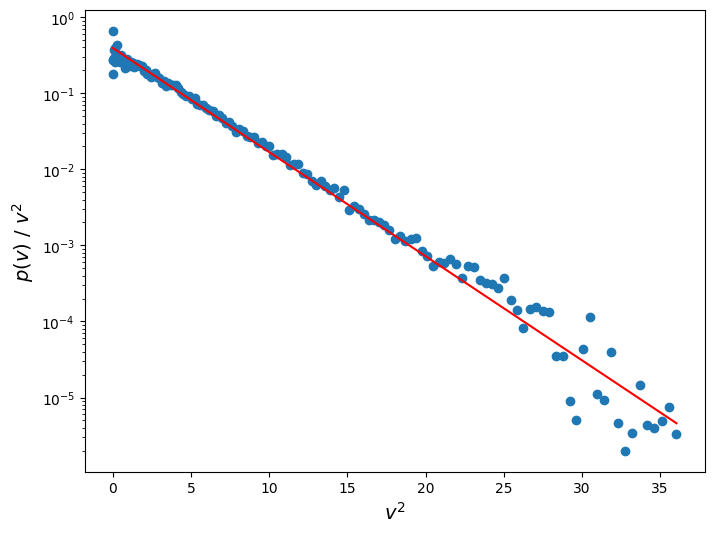

In [262]:
plt.figure(figsize=(8,6))

p = np.polyfit(idx ** 2, np.log(h / idx ** 2), deg=1)
plt.scatter(idx ** 2, h / idx ** 2)
t = np.linspace(0, idx[-1] ** 2, 100)
plt.plot(t, np.exp(p[0] * t + p[1]), c='red')

plt.ylabel('$p(v)~/~v^2$', fontsize=14)
plt.xlabel('$v^2$', fontsize=14)

plt.yscale('log')

## диффузия

Генерация начальных состояний
- ``` ./bin/generator -d 0.04 -t 1 -c 7 -f init-0.04-216.mdl --prefix ./configs/diffusion/gas ```
- ``` ./bin/generator -d 0.85 -t 1 -c 7 -f init-0.85-216.mdl --prefix ./configs/diffusion/liquid ```

Приведение к установившемуся режиму с заданными температурами (остальные аналогично)
- ``` ./bin/model --input configs/diffusion/gas/init-0.04-216.mdl -t 50 --scale 1 --relax 1 --save ./configs/diffusion/gas/diff-g-t-1.mdl ```

Набор данных для диффузии (остальные аналогично)
- ``` ./bin/model --input ./configs/diffusion/gas/diff-g-t-1.mdl -t 150 --diffusion --ovito 100 ```

In [50]:
def diff(x: np.ndarray, L, bar: bool=True):
    '''
        Функция, вычисляющая среднеквадратическое смещение
        x: np.ndarray[steps number, particle number, 6] -- основной массив
        (3 координаты, 3 скорости).
        L: list[int] -- список (или другой iterable) целых чисел, в которых 
        будет вычисляться среднеквадратическое отклонение.
        bar: bool -- флаг на progress bar.
        Для корректного использования необходимо передавать данные,
        полученные при моделировании с флагом "--diffusion".
    '''
    if len(x.shape) != 3 or x.shape[2] not in [3, 6]:
        raise ValueError('Array must have 3 dimensions [time step, particle, 6] or [time step, particle, 3]')

    if x.shape[2] == 6:
        x = x[:,:,:3]

    if L.__class__ is int:
        L = np.arange(1, L+1)
    
    pbar= tqdm(L) if bar else L

    diff_mean = np.array([
        np.mean(            # усреднение по частицам и шагам интегрирования
            np.sum( (x[i:] - x[:-i]) ** 2 , axis=-1 ) # квадрат смещения
        ) 
        for i in pbar       # i -- количество шагов
    ])

    return np.array(diff_mean), np.array(L, dtype=np.float64)

In [99]:
def mse(x: np.ndarray, y: np.ndarray):
    
    n = x.size
    k = ( (x * y).mean() - x.mean() * y.mean() ) / x.var()
    b = y.mean() - k * x.mean()
    d_k = np.sqrt( ( y.var() / x.var() ) / (n - 2) )
    d_b = d_k * np.sqrt( (x ** 2).mean() )

    return k, b, d_k, d_b

In [49]:
target_temp = [1, 1.3, 1.6, 1.9, 2.2, 2.5]
real_temp = {
    ch : [
    np.mean( np.fromfile(f'./outputs/diff-{ch}-t-{t}-energy.dat').reshape(-1,2)[-1000:,0] ) / 216 * 2 / 3
    for t in target_temp
] for ch in ['g', 'l']}
real_temp

{'g': [0.9760899109473001,
  1.293574073992828,
  1.6037678022470476,
  1.9005713541518345,
  2.1843899505238555,
  2.4915717486929494],
 'l': [1.0062832193157554,
  1.3165900865002642,
  1.6116442017797301,
  1.906103637196405,
  2.248402764546095,
  2.5329789159338136]}

### Эйнштейн-Смолуховский

Точки берутся в арифметической прогрессии

In [18]:
L = np.linspace(1, 100_000, num=100, dtype=int)

In [19]:
df = pd.DataFrame(index=L)

for t in target_temp:
    df[f'g-t-{t}'] = diff(np.fromfile(f'./outputs/diff-g-t-{t}.dat').reshape(-1, 216, 6), L=L)[0]

for t in target_temp:
    df[f'l-t-{t}'] = diff(np.fromfile(f'./outputs/diff-l-t-{t}.dat').reshape(-1, 216, 6), L=L)[0]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

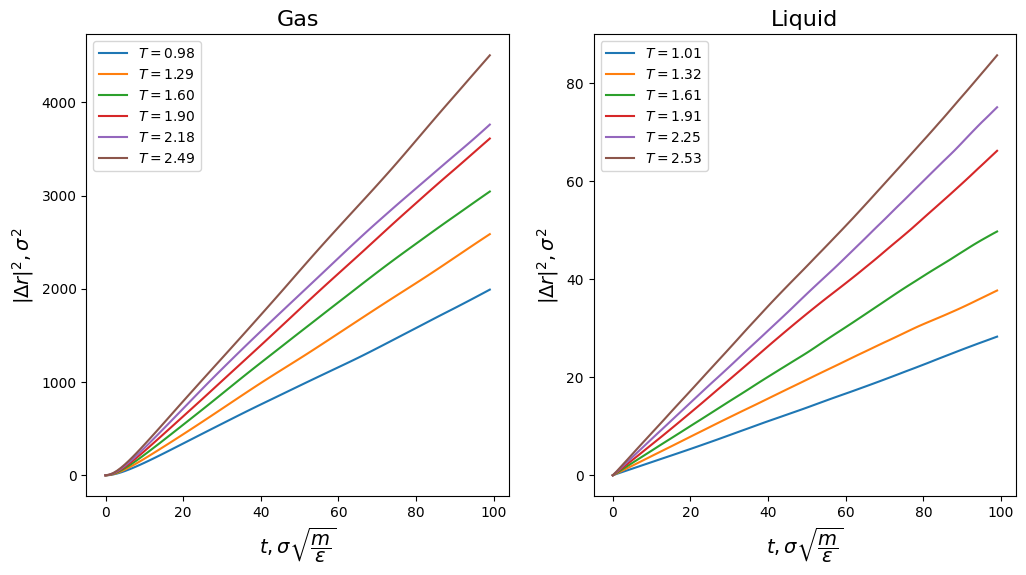

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

for t, r_g, r_l in zip(target_temp, real_temp['g'], real_temp['l']):
    ax[0].plot(df.index * 1e-3, df[f'g-t-{t}'], label=f'$T={r_g:.2f}$')
    ax[1].plot(df.index * 1e-3, df[f'l-t-{t}'], label=f'$T={r_l:.2f}$')

ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)

ax[0].set_title('Gas', fontsize=16)
ax[1].set_title('Liquid', fontsize=16)

ax[0].set_xlabel('$t, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=14)
ax[0].set_ylabel('$| \Delta r |^2, \sigma^2$', fontsize=14)
ax[1].set_xlabel('$t, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=14)
ax[1].set_ylabel('$| \Delta r |^2, \sigma^2$', fontsize=14)

plt.show()

In [48]:
df.to_csv('diffusion/df-0.04-0.85-100.csv')

In [194]:
d_koeff = {'g' : [], 'l' : []}
d_koeff_error = {'g' : [], 'l' : []}

cut = 20

for ch in ['g', 'l']:
    for t in target_temp:
        k, _, d_k, _ = mse(df.index.values[cut:] * 1e-3, df[f'{ch}-t-{t}'].values[cut:])
        d_koeff[ch].append(k / 6)
        d_koeff_error[ch].append(d_k / 6)

#### пример аппроксимации 

(для наглядной проверки того, что все сделал правильно)

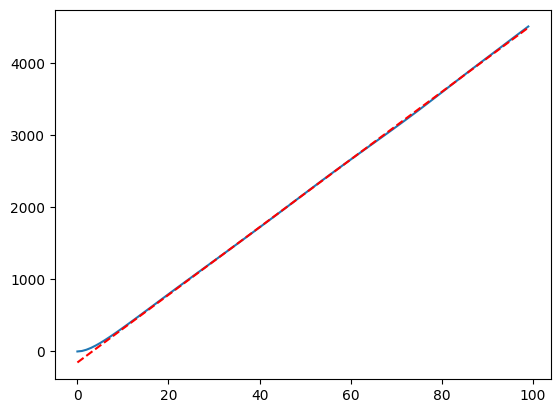

In [202]:
plt.plot(df.index * 1e-3, df['g-t-2.5'])

k, b, _, _ = mse(df.index.values[cut:] * 1e-3, df[f'g-t-2.5'].values[cut:])

plt.plot(df.index * 1e-3, df.index * 1e-3 * k + b, '--', c='r')
plt.show()

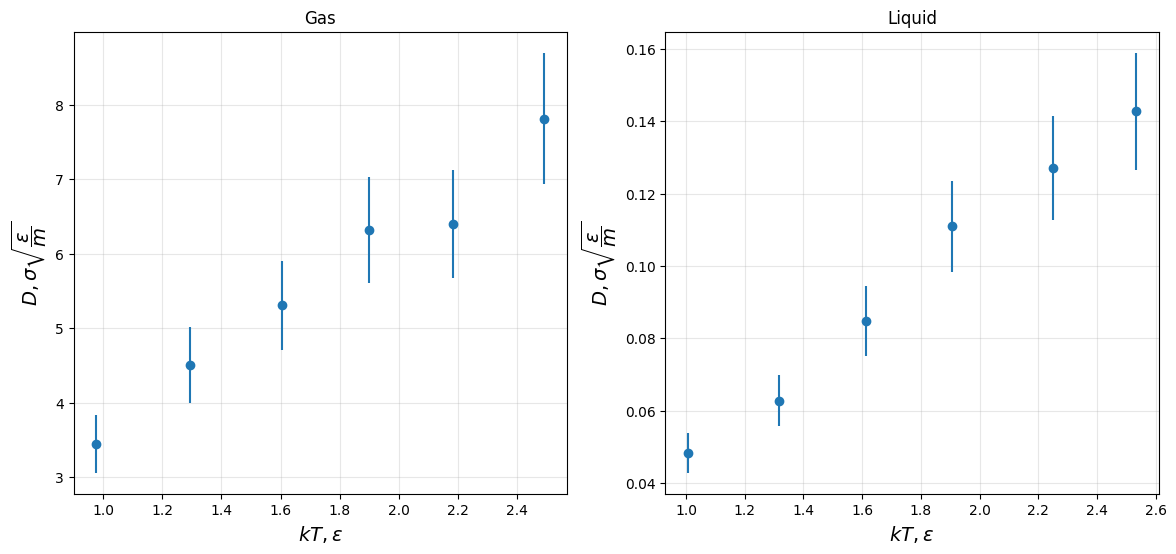

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].errorbar(real_temp['g'], d_koeff['g'], yerr=d_koeff_error['g'], fmt='o')
ax[1].errorbar(real_temp['l'], d_koeff['l'], yerr=d_koeff_error['l'], fmt='o')

ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)

ax[0].set_title('Gas')
ax[1].set_title('Liquid')

ax[0].set_xlabel('$kT, \\varepsilon$', fontsize=14)
ax[0].set_ylabel('$D, \sigma \sqrt{\dfrac{\\varepsilon}{m}}$', fontsize=14)
ax[1].set_xlabel('$kT, \\varepsilon$', fontsize=14)
ax[1].set_ylabel('$D, \sigma \sqrt{\dfrac{\\varepsilon}{m}}$', fontsize=14)

plt.show()

### Аппроксимация в лог. масштабе

In [67]:
L = np.unique(np.geomspace(1, 100_000, num=114, dtype=int)) # так полуается ровно 100 элементов

In [70]:
df_log = pd.DataFrame(index=L)

for t in target_temp:
    df_log[f'g-t-{t}'] = diff(np.fromfile(f'./outputs/diff-g-t-{t}.dat').reshape(-1, 216, 6), L=L)[0]

for t in target_temp:
    df_log[f'l-t-{t}'] = diff(np.fromfile(f'./outputs/diff-l-t-{t}.dat').reshape(-1, 216, 6), L=L)[0]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
df_log.to_csv('./diffusion/df-log-0.04-0.85-100.csv')

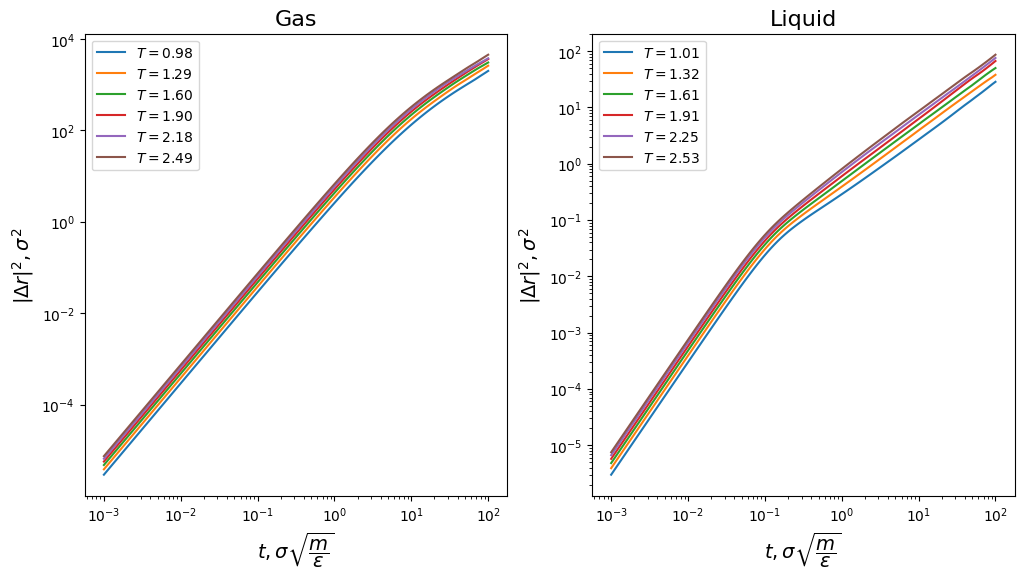

In [153]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

for t, r_g, r_l in zip(target_temp, real_temp['g'], real_temp['l']):
    ax[0].plot(df_log.index * 1e-3, df_log[f'g-t-{t}'], label=f'$T={r_g:.2f}$')
    ax[1].plot(df_log.index * 1e-3, df_log[f'l-t-{t}'], label=f'$T={r_l:.2f}$')

ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)

ax[0].set_title('Gas', fontsize=16)
ax[1].set_title('Liquid', fontsize=16)

ax[0].set_xlabel('$t, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=14)
ax[0].set_ylabel('$| \Delta r |^2, \sigma^2$', fontsize=14)
ax[1].set_xlabel('$t, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=14)
ax[1].set_ylabel('$| \Delta r |^2, \sigma^2$', fontsize=14)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

plt.show()

In [184]:
l_koeff = {'g' : [], 'l' : []}
l_koeff_error = {'g' : [], 'l' : []}

cut = {'g' : (60, 81), 'l' : (25, 41)}

for ch in ['g', 'l']:
    for t in target_temp:
        k1, b1, d_k1, d_b1 = mse( np.log( df_log.index.values[:cut[ch][0]] * 1e-3 ), np.log( df_log[f'{ch}-t-{t}'].values[:cut[ch][0]] ) )
        k2, b2, d_k2, d_b2 = mse( np.log( df_log.index.values[cut[ch][1]:] * 1e-3 ), np.log( df_log[f'{ch}-t-{t}'].values[cut[ch][1]:] ) )
        l_koeff[ch].append( (k1, b1, k2, b2) )
        l_koeff_error[ch].append( (d_k1, d_b1, d_k2, d_b2) )

#### пример аппроксимации 

(для наглядной проверки того, что все сделал правильно)

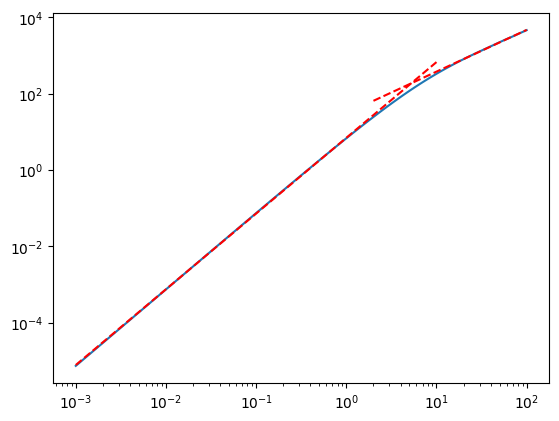

In [215]:
plt.plot(df_log.index * 1e-3, df_log['g-t-2.5'])

def f(x, k, b):
    return np.exp(b) * x ** k

t = np.geomspace(1e-3, 1e1, 3)
plt.plot(t, f(t, l_koeff['g'][-1][0], l_koeff['g'][-1][1]), '--', c='r')
t = np.geomspace(2, 1e2, 3)
plt.plot(t, f(t, l_koeff['g'][-1][2], l_koeff['g'][-1][3]), '--', c='r')

plt.xscale('log')
plt.yscale('log')

plt.show()

In [222]:
free_path_len = {'g' : [], 'l' : []}
free_path_len_error = {'g' : [], 'l' : []}

for ch in ['g', 'l']:
    for i in range(len(target_temp)):
        k1, b1, k2, b2 = l_koeff[ch][i]
        d_k1, d_b1, d_k2, d_b2 = l_koeff_error[ch][i]
        free_path_len[ch].append(
            np.exp( ( b1 * k2 - b2 * k1 ) / ( k2 - k1 ) / 2)
        )
        free_path_len_error[ch].append(
            free_path_len[ch][i] * np.sqrt(
                ( b2 - b1 ) ** 2 / ( k2 - k1 ) ** 4 * ( k2 ** 2 * d_k1 ** 2 + k1 ** 2 * d_k2 ** 2 ) + \
                ( k2 ** 2 * d_b1 ** 2 + k1 ** 2 * d_b2 ** 2 ) / ( k2 - k1 ) ** 2
            )
        )

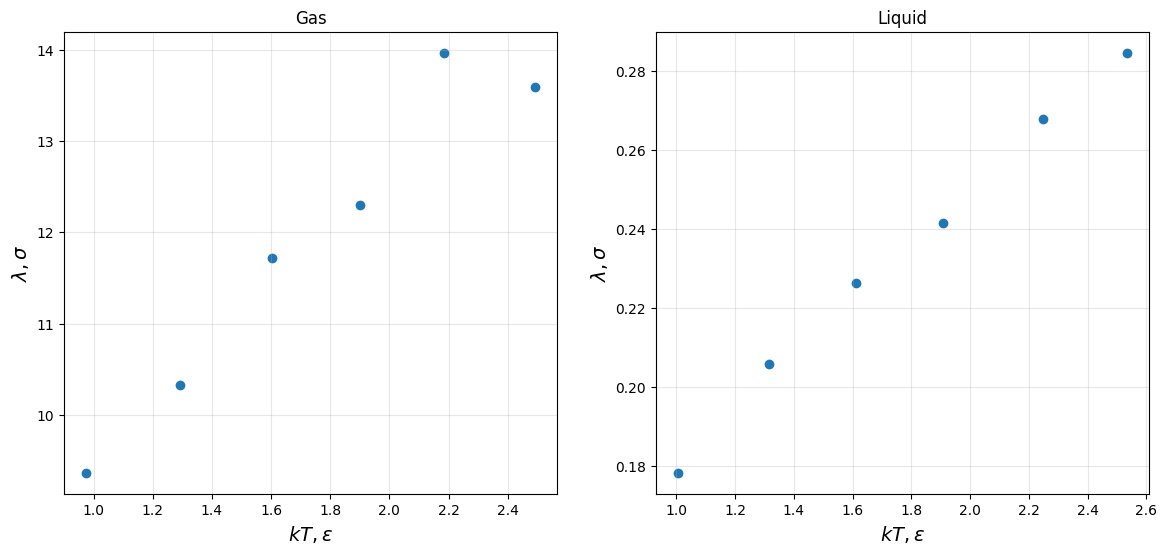

In [229]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].scatter(real_temp['g'], free_path_len['g'])
ax[1].scatter(real_temp['l'], free_path_len['l'])

ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)

ax[0].set_title('Gas')
ax[1].set_title('Liquid')

ax[0].set_xlabel('$kT, \\varepsilon$', fontsize=14)
ax[0].set_ylabel('$\lambda, \sigma$', fontsize=14)
ax[1].set_xlabel('$kT, \\varepsilon$', fontsize=14)
ax[1].set_ylabel('$\lambda, \sigma$', fontsize=14)

plt.show()

#### эффективное сечение

In [245]:
d_koeff['g']

[3.4486023817327784,
 4.508958357075377,
 5.306263667735184,
 6.318883484478081,
 6.402150281387963,
 7.815489276245297]

In [255]:
n = {'g' : 0.04, 'l' : 0.85}
Pi = {'g' : [], 'l' : []}
Pi_error = {'g' : [], 'l' : []}

for ch in ['g', 'l']:
    for i in range(len(target_temp)):
        Pi[ch].append(
            4 / 3 * np.sqrt(real_temp[ch][i] / np.pi) / n[ch] / d_koeff[ch][i]
        )
        Pi_error[ch].append(d_koeff_error[ch][i] / d_koeff[ch][i] * Pi[ch][i])

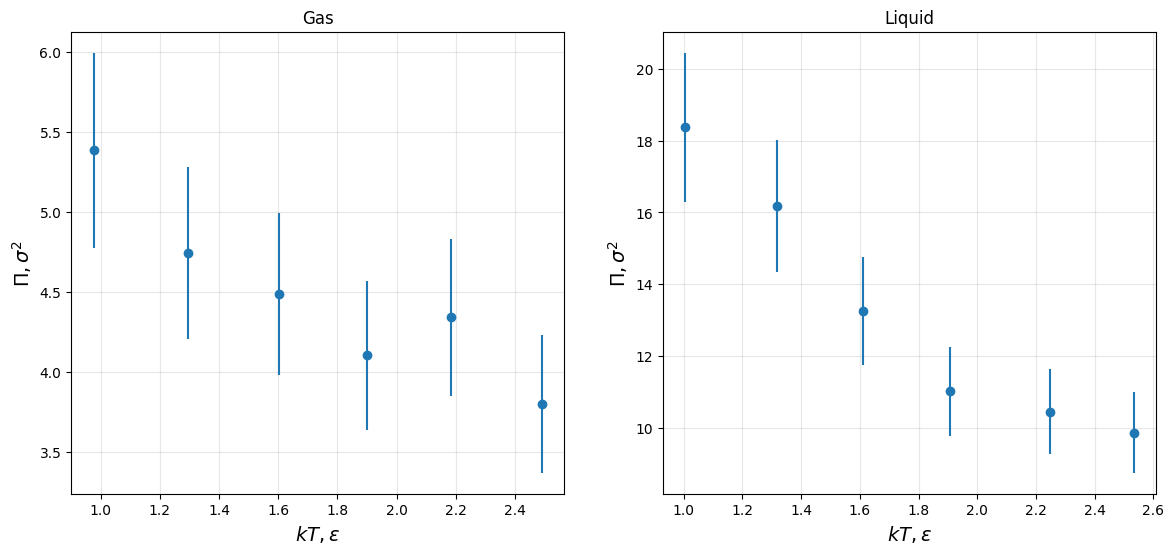

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].errorbar(real_temp['g'], Pi['g'], yerr=Pi_error['g'], fmt='o')
ax[1].errorbar(real_temp['l'], Pi['l'], yerr=Pi_error['l'], fmt='o')

ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)

ax[0].set_title('Gas')
ax[1].set_title('Liquid')

ax[0].set_xlabel('$kT, \\varepsilon$', fontsize=14)
ax[0].set_ylabel('$\Pi, \sigma^2$', fontsize=14)
ax[1].set_xlabel('$kT, \\varepsilon$', fontsize=14)
ax[1].set_ylabel('$\Pi, \sigma^2$', fontsize=14)

plt.show()

## VACF

In [292]:
def VACF(velocities):
    size = velocities.shape
    res = np.zeros((size[0], size[1]))

    for p in tqdm(range(size[1])):
        conv = np.zeros((size[0], 3), dtype=np.complex128)

        for dim in range(3):
            v = velocities[:, p, dim]
            v = np.concatenate((v, np.zeros(v.shape[0])))

            F = np.fft.fft(v)
            F *= np.conj(F)

            conv[:, dim] = np.real(np.fft.ifft(F)[:size[0]]) / np.arange(size[0], 0, -1)

        res[:, p] = np.sum(conv, axis=1)

    return np.mean(res, axis=1)

In [276]:
d = np.fromfile('./outputs/diff-l-t-1.dat').reshape(-1, 216, 6)

In [350]:
cut = {'g' : 50000, 'l' : 10000}

vacf = {
    ch : [
        VACF(
            np.fromfile(f'./outputs/diff-{ch}-t-{t}.dat').reshape(-1, 216, 6)[:,:,3:]
        )[:cut[ch]]
        for t in target_temp
    ]
    for ch in ['g', 'l']
}

  0%|          | 0/216 [00:00<?, ?it/s]

/tmp/ipykernel_14614/3117972772.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  res[:, p] = np.sum(conv, axis=1)


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

In [393]:
pd.DataFrame(vacf['g']).to_csv('./vacf/vacf-g-5e4.csv')
pd.DataFrame(vacf['l']).to_csv('./vacf/vacf-g-1e4.csv')

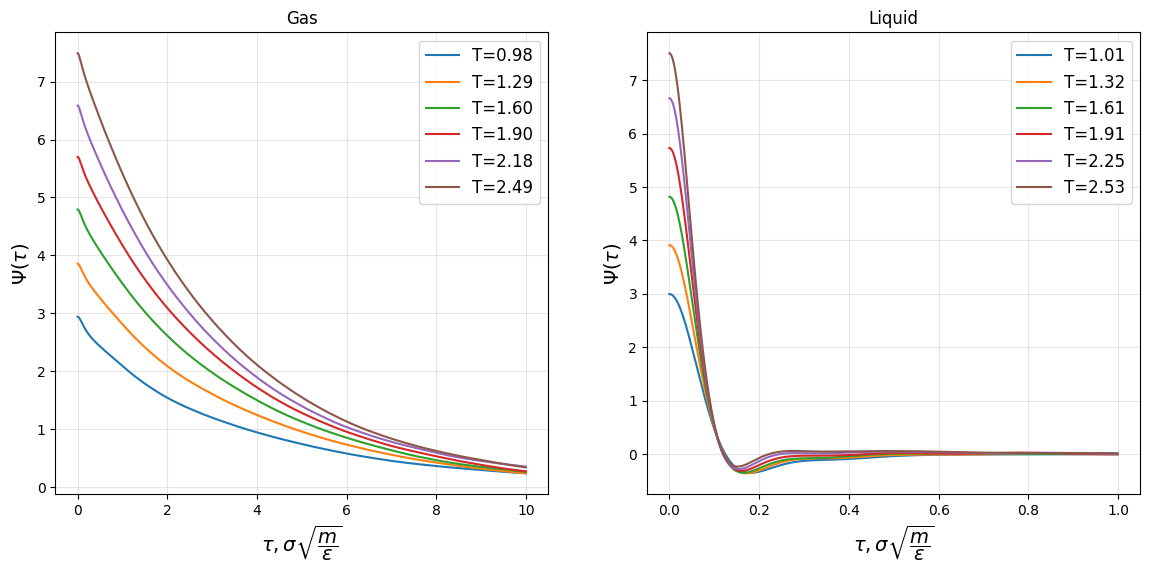

In [641]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

cut = {'g' : 10000, 'l' : 1000}

for i in range(6):
    ax[0].plot(np.arange(0, cut['g']) * 1e-3, vacf['g'][i][:cut['g']], label=f'T={real_temp["g"][i]:.2f}')
    ax[1].plot(np.arange(0, cut['l']) * 1e-3, vacf['l'][i][:cut['l']], label=f'T={real_temp["l"][i]:.2f}')

ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

ax[0].set_title('Gas')
ax[1].set_title('Liquid')

ax[0].set_xlabel('$\\tau, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=14)
ax[0].set_ylabel('$\Psi(\\tau)$', fontsize=14)
ax[1].set_xlabel('$\\tau, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=14)
ax[1].set_ylabel('$\Psi(\\tau)$', fontsize=14)

plt.show()

In [361]:
vacf_int = {'g' : [], 'l' : []}

for j in range(6):
    tmp_int = []
    for i in range(0, 50000, 100):
        tmp_int.append(np.trapz(vacf['g'][j][:i], np.arange(0, vacf['g'][j][:i].shape[0]) * 1e-3))
    vacf_int['g'].append(np.array(tmp_int))

    tmp_int = []
    for i in range(0, 10000, 10):
        tmp_int.append(np.trapz(vacf['l'][j][:i], np.arange(0, vacf['g'][j][:i].shape[0]) * 1e-3))
    vacf_int['l'].append(np.array(tmp_int))

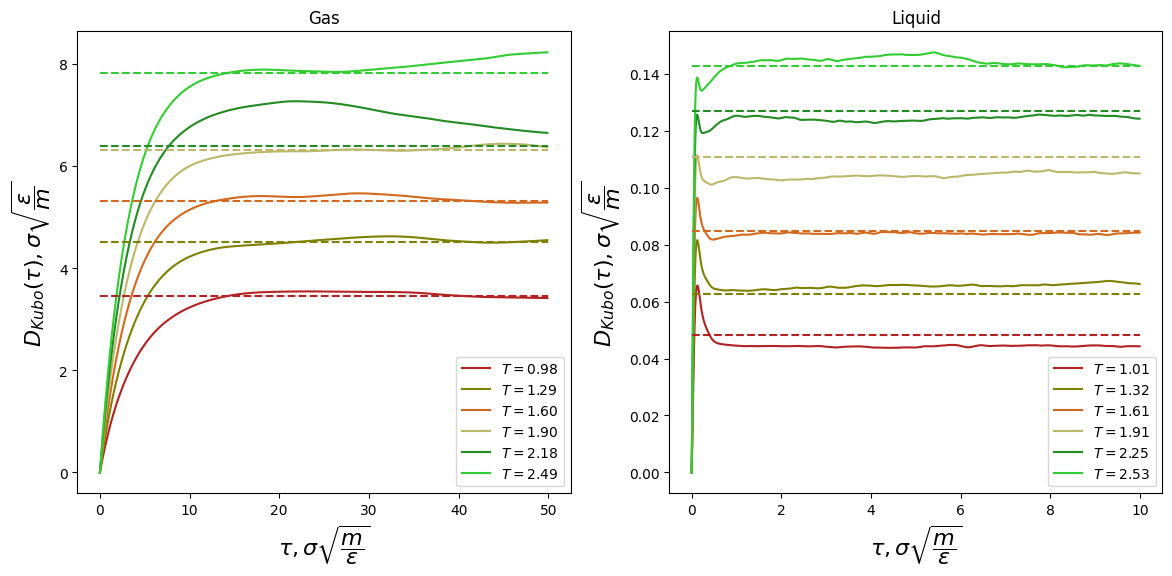

In [643]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

cols = ['firebrick', 'olive', 'chocolate', 'darkkhaki', 'forestgreen', 'limegreen']

for i in range(6):
    ax[0].plot(np.arange(0, 50000, 100) * 1e-3, vacf_int['g'][i] / 3, c=cols[i], label=f'$T={real_temp["g"][i]:.2f}$')
    ax[1].plot(np.arange(0, 10000,  10) * 1e-3, vacf_int['l'][i] / 3, c=cols[i], label=f'$T={real_temp["l"][i]:.2f}$')

ax[0].hlines(d_koeff['g'], 0, 50, linestyle='--', colors=cols)
ax[1].hlines(d_koeff['l'], 0, 10, linestyle='--', colors=cols)

ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)

ax[0].set_title('Gas')
ax[1].set_title('Liquid')

ax[0].set_xlabel('$\\tau, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=16)
ax[0].set_ylabel('$D_{Kubo}(\\tau), \sigma \sqrt{\dfrac{\\varepsilon}{m}}$', fontsize=16)
ax[1].set_xlabel('$\\tau, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=16)
ax[1].set_ylabel('$D_{Kubo}(\\tau), \sigma \sqrt{\dfrac{\\varepsilon}{m}}$', fontsize=16)

plt.show()

In [654]:
cut = {'g' : 200, 'l' : 100}

d_koeff_kubo = {
    ch : [np.mean(vacf_int[ch][i][cut[ch]:] / 3) for i in range(6)]
    for ch in ['g', 'l']
}

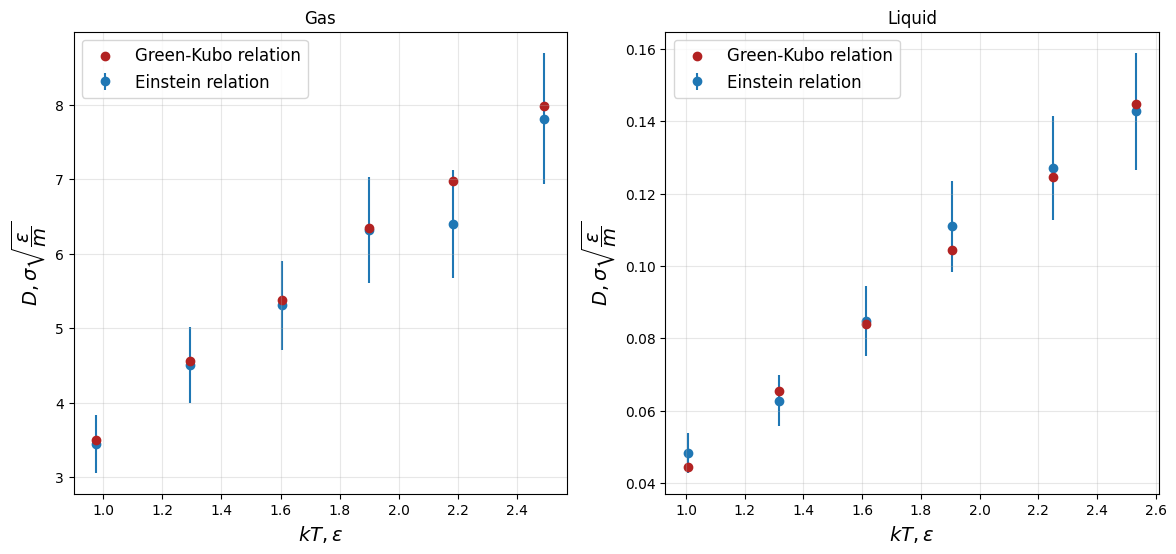

In [655]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].errorbar(real_temp['g'], d_koeff['g'], yerr=d_koeff_error['g'], fmt='o', zorder=0, label='Einstein relation')
ax[1].errorbar(real_temp['l'], d_koeff['l'], yerr=d_koeff_error['l'], fmt='o', zorder=0, label='Einstein relation')

ax[0].scatter(real_temp['g'], d_koeff_kubo['g'], c='firebrick', label='Green-Kubo relation')
ax[1].scatter(real_temp['l'], d_koeff_kubo['l'], c='firebrick', label='Green-Kubo relation')

ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)

ax[0].legend(loc='upper left', fontsize=12)
ax[1].legend(loc='upper left', fontsize=12)

ax[0].set_title('Gas')
ax[1].set_title('Liquid')

ax[0].set_xlabel('$kT, \\varepsilon$', fontsize=14)
ax[0].set_ylabel('$D, \sigma \sqrt{\dfrac{\\varepsilon}{m}}$', fontsize=14)
ax[1].set_xlabel('$kT, \\varepsilon$', fontsize=14)
ax[1].set_ylabel('$D, \sigma \sqrt{\dfrac{\\varepsilon}{m}}$', fontsize=14)

plt.show()

## RDF

In [550]:
def calculate_rdf(file, rmax, bins):
    if not os.path.exists(f'./ovito/{file}.xyz'):
        raise ValueError(f'File ./ovito/{file}.xyz does not exist')
    if not os.path.exists('./rdf'):
        os.mkdir('./rdf')
    if not os.path.exists(f'./rdf/{file}'):
        os.mkdir(f'./rdf/{file}')

    with open(f'./ovito/{file}.xyz', 'r') as rd:
        s = rd.readline()
        i = 0
        out = None
        while s!= "":
            if s == '216\n':
                if out is not None:
                    out.close()
                i += 1
                out = open(f'./rdf/{file}/{file}-{i}.xyz', 'w')
            out.write(s)
            s = rd.readline()
        out.close()
    
    res, dists = Analysis(read(f'./rdf/{file}/{file}-{1}.xyz')).get_rdf(rmax, bins, return_dists=True)[0]
    for k in tqdm(range(2, i + 1)):
        res += Analysis(read(f'./rdf/{file}/{file}-{k}.xyz')).get_rdf(rmax, bins)[0]

    return res / i, dists

In [554]:
rdf = {'g' : [], 'l' : []}

for ch in ['g', 'l']:
    for i in range (6):
        if i == 0  and ch == 'g':
            tmp = calculate_rdf(f'diff-{ch}-t-{target_temp[i]}', 3, 200)
            rdf[ch].append(tmp[0])
            dists = tmp[1]
            del tmp
            continue

        rdf[ch].append(
            calculate_rdf(f'diff-{ch}-t-{target_temp[i]}', 3, 200)[0]
        )

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

In [559]:
pd.DataFrame(rdf['g']).to_csv('./rdf/data-g.csv')
pd.DataFrame(rdf['l']).to_csv('./rdf/data-g.csv')

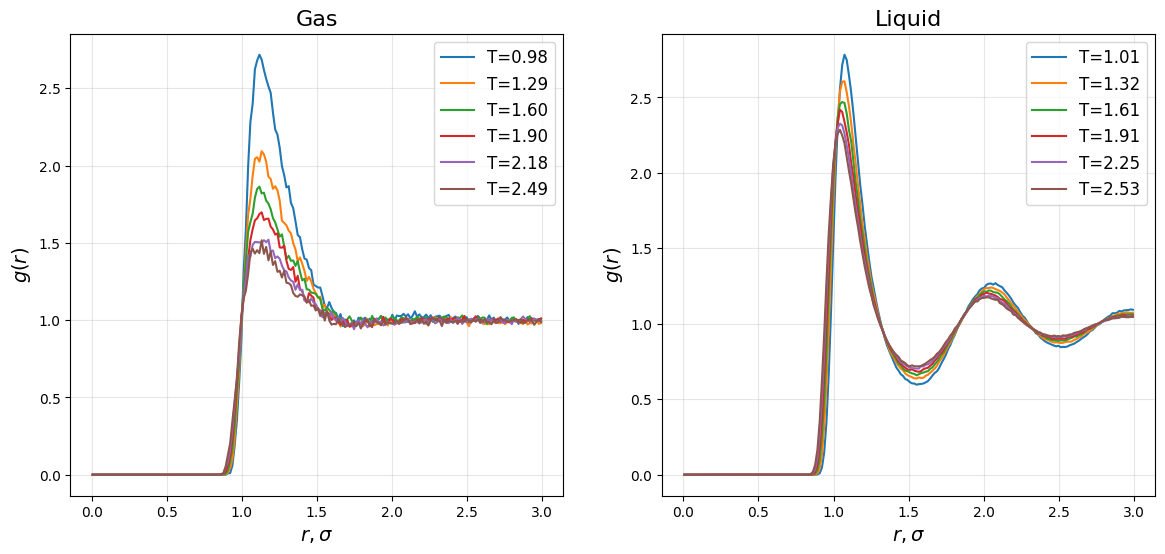

In [659]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

for i in range(6):
    ax[0].plot(dists, rdf['g'][i], label=f'T={real_temp["g"][i]:.2f}')
    ax[1].plot(dists, rdf['l'][i], label=f'T={real_temp["l"][i]:.2f}')

ax[0].grid(alpha=.3)
ax[1].grid(alpha=.3)

ax[0].legend(loc='upper right', fontsize=12)
ax[1].legend(loc='upper right', fontsize=12)

ax[0].set_title('Gas', fontsize=16)
ax[1].set_title('Liquid', fontsize=16)

ax[0].set_xlabel('$r, \sigma$', fontsize=14)
ax[0].set_ylabel('$g(r)$', fontsize=14)
ax[1].set_xlabel('$r, \sigma$', fontsize=14)
ax[1].set_ylabel('$g(r)$', fontsize=14)

plt.show()

In [582]:
rdf_r = {'g' : [], 'l' : []}

for ch in ['g', 'l']:
    for i in range(6):
        k = 0
        while rdf[ch][i][k] == 0:
            k += 1
        rdf_r[ch].append(dists[k])

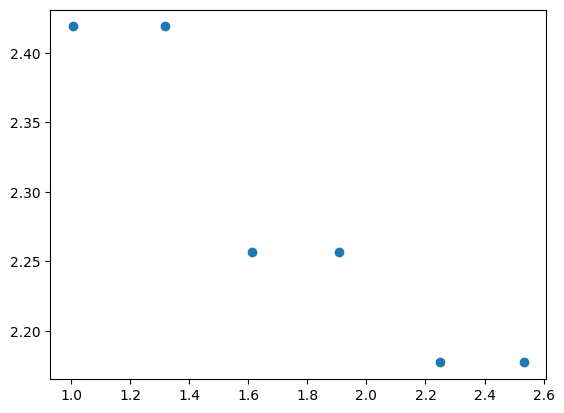

In [587]:
plt.scatter(real_temp['l'], np.array(rdf_r['l']) ** 2 * np.pi)

## Твердая фаза

In [600]:
d = np.fromfile('./outputs/solid-relaxed.dat').reshape(-1, 216, 6)
e = np.fromfile('./outputs/solid-relaxed-energy.dat').reshape(-1, 2)

0.5556712392898112


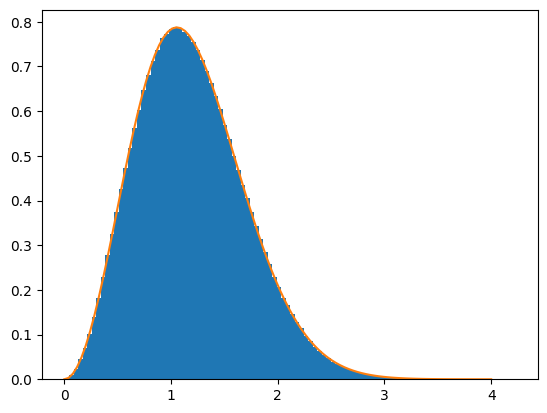

In [604]:
plt.hist(
    np.sqrt( (d[90000:,:,3:] ** 2).sum(axis=-1) ).flatten(),
    bins=100,
    density=True
)

T = np.mean(e[-1000:,0]) / 216 * 2 / 3
print(T)

t = np.linspace(0, 4, 100)
plt.plot(t, maxwell(t, T))

plt.show()

In [617]:
df_solid, L = diff(d, L=range(1, 10000, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

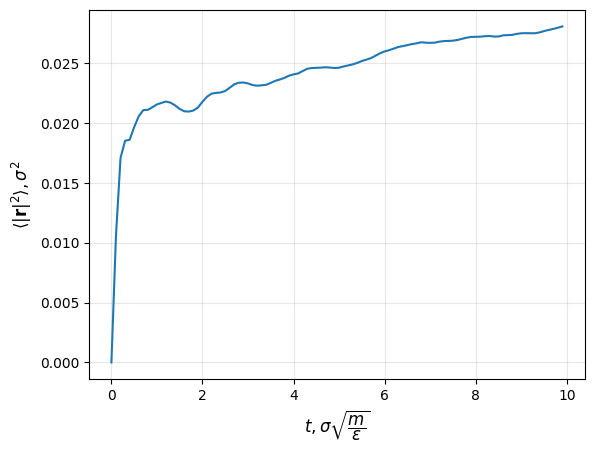

In [666]:
plt.plot(L * 1e-3, df_solid)

plt.xlabel('$t, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=12)
plt.ylabel('$\langle |\mathbf{r}|^2 \\rangle, \sigma^2$', fontsize=12)

plt.grid(alpha=.3)
#plt.yscale('log')
#plt.xscale('log')

In [625]:
vacf_solid = VACF(d[90000:,:,3:])

  0%|          | 0/216 [00:00<?, ?it/s]

/tmp/ipykernel_14614/3117972772.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  res[:, p] = np.sum(conv, axis=1)


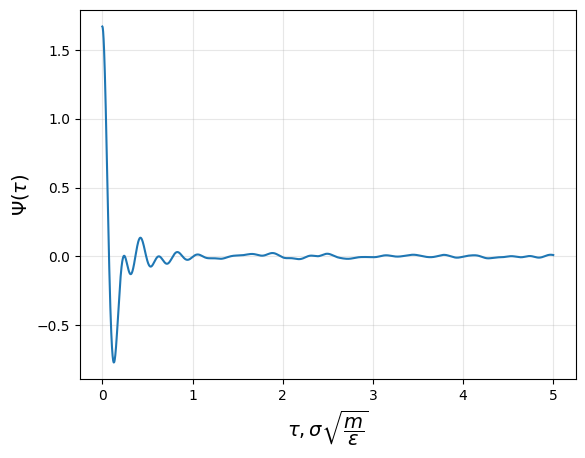

In [671]:
plt.plot(np.arange(5000) * 1e-3, vacf_solid[:5000])

plt.xlabel('$\\tau, \sigma \sqrt{\dfrac{m}{\\varepsilon}}$', fontsize=14)
plt.ylabel('$\Psi(\\tau)$', fontsize=14)

plt.grid(alpha=.3)

In [630]:
rdf_solid, dists_solid = calculate_rdf('solid-relaxed', 2.5, 200)

  0%|          | 0/1499 [00:00<?, ?it/s]

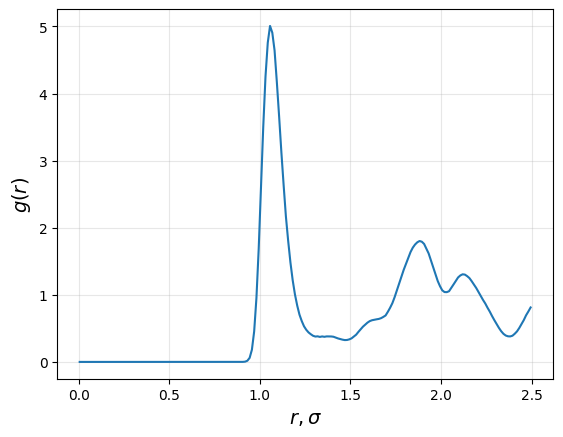

In [672]:
plt.plot(dists_solid, rdf_solid)

plt.xlabel('$r, \sigma$', fontsize=14)
plt.ylabel('$g(r)$', fontsize=14)

plt.grid(alpha=.3)

plt.show()